In [4]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd

In [ ]:
def load_results(gal_type,dataset,runtype):
    path = f"{gal_type}_{dataset}_{runtype}_coadd_results.npz"
    data = np.load(path)
    # wavelength grid
    wave = data['wavelength']    
    # valid bins
    valid_bins = data['valid_bins']
    # smoothed residuals (gaussian)
    snr_narrow = data['snr_narrow']  #3 A
    # snr_broad = data['snr_broad']  #15 A
    noise = data['noise']
    noise = noise[valid_bins]
    valid_wave = wave[valid_bins]
    valid_snr_narrow = snr_narrow[valid_bins]
    # valid_snr_broad = snr_broad[valid_bins]
    # valid_residual = data['residual'][valid_bins]  
    return valid_snr_narrow,noise,valid_wave

In [ ]:
def find_unassociated_extrema(wave,snr,min_wave=None):
    n_extrema = 5
    # all known observed emission lines
    known_lines =  [770.409, 780.324, 937.814, 949.742, 977.030, 989.790, 991.514,
                        991.579, 1025.722, 1031.912, 1037.613, 1066.660, 1215.670,
                        1238.821, 1242.804, 1260.422, 1264.730, 1302.168, 1334.532, 
                        1335.708, 1393.755, 1397.232, 1399.780, 1402.770, 1486.496,
                        1548.187, 1550.772, 1640.420, 1660.809, 1666.150, 1746.823,
                        1748.656, 1854.716, 1862.790, 1892.030, 1908.734, 2142.780,
                        2320.951, 2323.500, 2324.690, 2648.710, 2733.289, 2782.700,
                        2795.528, 2802.705, 2829.360, 2835.740, 2853.670, 2868.210,
                        2928.000, 2945.106, 3132.794, 3187.745, 3203.100, 3312.329,
                        3345.821, 3425.881, 3444.052, 3466.497, 3466.543, 3487.727,
                        3586.320, 3662.500, 3686.831, 3691.551, 3697.157, 3703.859, 
                        3711.977, 3721.945, 3726.032, 3728.815, 3734.369, 3750.158,
                        3758.920, 3770.637, 3797.904, 3835.391, 3839.270, 3868.760, 
                        3888.647, 3889.064, 3891.280, 3911.330, 3967.470, 3970.079,
                        4026.190, 4068.600, 4071.240, 4076.349, 4101.742, 4143.761,
                        4178.862, 4180.600, 4233.172, 4227.190, 4287.394, 4303.176,
                        4317.139, 4340.471, 4363.210, 4412.300, 4414.899, 4416.830, 
                        4452.098, 4471.479, 4489.183, 4491.405, 4510.910, 4522.634,
                        4555.893, 4582.835, 4583.837, 4629.339, 4634.140, 4640.640,
                        4641.850, 4647.420, 4650.250, 4651.470, 4658.050, 4685.710,
                        4711.260, 4740.120, 4861.333, 4893.370, 4903.070, 4923.927,
                        4958.911, 5006.843, 5018.440, 5084.770, 5145.750, 5158.890,
                        5169.033, 5176.040, 5197.577, 5200.257, 5234.625, 5236.060,
                        5270.400, 5276.002, 5276.380, 5302.860, 5309.110, 5316.615,
                        5316.784, 5335.180, 5424.220, 5517.709, 5537.873, 5637.600,
                        5677.000, 5695.920, 5720.700, 5754.590, 5801.330, 5811.980,
                        5875.624, 6046.440, 6087.000, 6300.304, 6312.060, 6347.100,
                        6363.776, 6369.462, 6374.510, 6516.081, 6548.050, 6562.819,
                        6583.460, 6716.440, 6730.810, 7002.230, 7005.870, 7065.196, 
                        7135.790, 7155.157, 7170.620, 7172.000, 7236.420, 7237.260,
                        7254.448, 7262.760, 7281.349, 7319.990, 7330.730, 7377.830,
                        7411.160, 7452.538, 7468.310, 7611.000, 7751.060, 7816.136,
                        7868.194, 7889.900, 7891.800, 8236.790, 8392.397, 8413.318,
                        8437.956, 8446.359, 8467.254, 8498.020, 8502.483, 8542.090,
                        8545.383, 8578.700, 8598.392, 8616.950, 8662.140, 8665.019,
                        8680.282, 8703.247, 8711.703, 8750.472, 8862.782, 8891.910, 
                        9014.909, 9068.600, 9229.014, 9531.100, 9545.969, 9824.130,
                        9850.260, 9913.000, 10027.730, 10031.160, 10049.368, 10286.730,
                        10320.490, 10336.410, 10746.800, 10830.340, 10938.086 ]
    # old from NIST
    # known_lines = [
    #     # Emission lines
    #     1025, 1215, 1240, 1265, 1309, 1394, 1403, 1533, 1549, 1640, 
    #     1661, 1666, 1882, 1892, 1907, 1908, 2324, 2325, 2422, 2425, 
    #     2796, 2803, 3346, 3426, 3726, 3728, 3868, 3889, 3890, 3967, 
    #     3970, 4072, 4101, 4340, 4363, 4685, 4861, 4959, 5007, 5411, 
    #     5577, 5755, 5876, 6300, 6312, 6363, 6548, 6562, 6583, 6716, 
    #     6730, 7135, 7751, 9071, 9532,
        
    #     # Absorption lines
    #     1260, 1302, 1304, 1334, 1394, 1403, 1501, 1526, 1549, 1608, 
    #     1670, 1808, 1854, 1862, 2026, 2344, 2374, 2382, 2389, 2796, 
    #     2803, 3889, 3933, 3968, 3970, 4101, 4307, 4340, 4861, 5175, 
    #     5889, 5892, 5895, 6562, 8500, 8544, 8664]
    
    
    # Find all peaks and valleys
    peaks, _ = find_peaks(snr)
    valleys, _ = find_peaks(-snr)

    # only need those NOT within 3 A of known lines
    unassociated_peaks = []
    unassociated_valleys = []

    # filter peaks and valleys
    if min_wave:
        peaks = [peak for peak in peaks if wave[peak] >= min_wave]
        valleys = [valley for valley in valleys if wave[valley] >= min_wave]
    
    # NOTE: worth marking only if not WITHIN 3
    for peak in peaks:
        associated = False
        for line in known_lines:
            if abs(wave[peak] - line) <= 3:
                associated = True
                break
        if not associated:
            unassociated_peaks.append(peak)
    
    for valley in valleys:
        associated = False
        for line in known_lines:
            if abs(wave[valley] - line) <= 3:
                associated = True
                break
        if not associated:
            unassociated_valleys.append(valley)

    # Sort by absolute SNR value and select top n_extrema
    unassociated_peaks = sorted(unassociated_peaks, key=lambda x: abs(snr[x]), reverse=True)[:n_extrema]
    unassociated_valleys = sorted(unassociated_valleys, key=lambda x: abs(snr[x]), reverse=True)[:n_extrema]

    peaks_info = {
        'indices': unassociated_peaks,
        'wavelengths': wave[unassociated_peaks],
        'snr_values': snr[unassociated_peaks]
    }
    
    valleys_info = {
        'indices': unassociated_valleys,
        'wavelengths': wave[unassociated_valleys],
        'snr_values': snr[unassociated_valleys]
    }
    
    return peaks_info, valleys_info

In [ ]:
def plot_SNR(snr,valid_wave,gal_type,dataset,runtype):
    plt.figure(figsize=(14, 6))
    plt.plot(valid_wave, snr,color = 'g',alpha = 0.8,zorder=2)
    min_wave, max_wave = plt.xlim()
    if dataset == 'loa' and runtype== 'skyfiber':
        if gal_type == 'BGS': 
            min_wave = 2446 
        else:
            min_wave = 1847
        plt.xlim(min_wave,max_wave)
        peaks, valleys = find_unassociated_extrema(valid_wave, snr,min_wave)
        mask = valid_wave >= min_wave
        plt.ylim(-6.5, 6.5)
    elif dataset == 'iron' and gal_type == 'LRG':
        min_wave = 1754 
        plt.xlim(min_wave,max_wave)
        peaks, valleys = find_unassociated_extrema(valid_wave, snr,min_wave)
        mask = valid_wave >= min_wave
    else:
        peaks, valleys = find_unassociated_extrema(valid_wave, snr)
        min_wave, max_wave = plt.xlim()
    # old
    # lines =[
    #     # emission lines
    #     (1025,'LyB', 'r',3), (1215,'LyA', 'r',3), (1240, 'N V', 'r',3), (1265, 'Si II', 'r',5), (1309, 'Si II', 'r',3),
    #     (1394, 'Si IV', 'r',3), (1403, 'Si IV', 'r',3), (1533, 'Si II', 'r',5), (1549, 'C IV', 'r',-5),
    #     (1640, 'He II', 'r',5), (1661, 'O III', 'r',-5), (1666, 'O III', 'r',6), (1882, 'Si III', 'r',6), (1892, 'Si III', 'r',3),
    #     (1907, 'C III', 'r',5), (1908, 'C III', 'r',-4), (2324, 'C II', 'r',-6), (2325, 'C II', 'r',-4), (2422, 'Ne IV', 'r',-4),
    #     (2425, 'Ne IV', 'r',5), (2796, 'Mg II', 'r',3), (2803, 'Mg II', 'r',-5), (3346, 'Ne V', 'r',3), (3426, 'Ne V', 'r',3),
    #     (3726, 'O II', 'r',-5), (3728, 'O II', 'r',-6), (3868, 'Ne III', 'r',3), (3889, 'He I/Hζ', 'r',-4), (3890, 'H8', 'r',6),
    #     (3967, 'Ne III', 'r',-4), (3970, 'Hε', 'r',-6), (4101, 'Hδ', 'r',-4), (4340, 'Hγ', 'r',4), (4363, 'O III', 'r',3),
    #     (4685, 'He II', 'r',3), (4861, 'Hβ', 'r',3), (4959, 'O III', 'r',3), (5007, 'O III', 'r',-4), (5411, 'He II', 'r',3),
    #     (5577, 'O I', 'r',3), (5755, 'N II', 'r',5), (5876, 'He I', 'r',3), (6300, 'O I', 'r',3), (6312, 'S III', 'r',5),
    #     (6363, 'O I', 'r',3), (4685, 'He II', 'r',3), (6548, 'N II', 'r',4), (6562, 'Hα', 'r',-4), (6583, 'N II', 'r',-5), 
    #     (6716, 'S II', 'r',5), (6730, 'S II', 'r',-5), (7135, 'Ar III', 'r',3), (7751, 'Ar III', 'r',3),
    #     (9071, 'S III', 'r',3), (9532, 'S III', 'r',3),

    #     # absorption lines
    #     (1260,'Si II', 'b',3), (1302,'O I', 'b',3), (1304,'Si II', 'b',3), (1334,'C II', 'b',3), (1394,'Si IV', 'b',3),
    #     (1403,'Si IV', 'b',3), (1501,'S V', 'b',3), (1526,'Si II', 'b',3), (1549,'C IV', 'b',-5), (1608,'Fe II', 'b',3),
    #     (1670,'Al II', 'b',3), (1808,'Si II', 'b',3), (1854,'Al III', 'b',4), (1862,'Al III', 'b',-5), (2026,'Mg I', 'b',3),
    #     (2324,'Fe II', 'b',6), (2374,'Fe II', 'b',6), (2382,'Fe II', 'b',-3), (2389,'Fe II', 'b',-6), (2796,'Mg II', 'b',3),
    #     (2803,'Mg II', 'b',-5), (3889,'Hζ', 'b',-3), (3933,'K', 'b',5), (3968,'H', 'b',3), (3970,'Hε', 'b',-6),
    #     (4101,'Hδ', 'b',-4), (4307,'G', 'b',3), (4340,'Hγ', 'b',4), (4861,'Hβ', 'b',4), (5175,'Mg I', 'b',3),
    #     (5889,'D2', 'b',5), (5892,'D', 'b',6), (5895,'D1', 'b',-5), (6562,'Hα', 'b',3), (8500,'Ca II', 'b',3), 
    #     (8544,'Ca II', 'b',3), (8664,'Ca II', 'b',3)
    # ]
    # updated emission lines! 
    lines = [
        (770.409, "Ne VIII"), (780.324, "Ne VIII"), (937.814, "Lyε"), (949.742, "Lyδ"), (977.030, "C III"), 
        (989.790, "N III"), (991.514, "N III"), (991.579, "N III"), (1025.722, "Lyβ"), (1031.912, "O VI"), 
        (1037.613, "O VI"), (1066.660, "Ar I"), (1215.670, "Lyα"), (1238.821, "N V"), (1242.804, "N V"), 
        (1260.422, "Si II"), (1264.730, "Si II"), (1302.168, "O I"), (1334.532 ,"C II"), (1335.708, "C II"), 
        (1393.755, "Si IV"), (1397.232, "O IV]"), (1399.780, "O IV]"), (1402.770, "Si IV"), (1486.496, "N IV]"),
        (1548.187, "C IV"), (1550.772, "C IV"), (1640.420, "He II"), (1660.809, "O III]"), (1666.150, "O III]"), 
        (1746.823, "N III]"),(1748.656, "N III]"), (1854.716, "Al III"), (1862.790, "Al III"), (1892.030, "Si III]"), 
        (1908.734, "C III]"), (2142.780, "N II]"), (2320.951, "[O III]"), (2323.500, "C II]"), (2324.690, "C II]"), 
        (2648.710, "[Fe XI]"), (2733.289, "He II"), (2782.700, "[Mg V]"), (2795.528, "Mg II]"), (2802.705, "Mg II]"), 
        (2829.360, "[Fe IV]"), (2835.740, "[Fe IV]"), (2853.670, "[Ar IV]"), (2868.210, "[Ar IV]"),
        (2928.000, "[Mg V]"), (2945.106, "He I"), (3132.794, "O III"), (3187.745, "He I"), (3203.100, "He II"), 
        (3312.329, "O III"), (3345.821, "[Ne V]"), (3425.881, "[Ne V]"), (3444.052, "O III"), (3466.497, "[N I]"), 
        (3466.543, "[N I]"), (3487.727, "He I"), (3586.320, "[Fe VII]"), (3662.500, "[Fe VI]"), (3686.831, "H19"), 
        (3691.551, "H18"), (3697.157, "H17"), (3703.859, "H16"), (3711.977, "H15"), (3721.945, "H14"), 
        (3726.032, "[O II]"), (3728.815, "[O II]"), (3734.369, "H13"), (3750.158, "H12"), (3758.920, "[Fe VII]"), 
        (3770.637, "H11"), (3797.904, "H10"), (3835.391, "H9"), (3839.270, "[Fe V]"), (3868.760, "[Ne III]"),
        (3888.647, "He I"), (3889.064, "H8"), (3891.280, "[Fe V]"), (3911.330, "[Fe V]"), (3967.470, "[Ne III]"), 
        (3970.079, "Hε"),(4026.190, "He I"), (4068.600, "[S II]"), (4071.240, "[Fe V]"), (4076.349, "[S II]"), 
        (4101.742, "Hδ"), (4143.761, "He I"), (4178.862, "Fe II"), (4180.600,"[Fe V]" ), (4233.172, "Fe II"), 
        (4227.190, "[Fe V]"), (4287.394, "[Fe II]"), (4303.176, "Fe II"), (4317.139, "O II"), (4340.471, "Hγ"), 
        (4363.210, "[O III]"), (4412.300, "[Ar XIV]	"), (4414.899, "O II"), (4416.830, "Fe II"), (4452.098, "[Fe II]"), 
        (4471.479, "He I"), (4489.183, "Fe II"), (4491.405, "Fe II"), (4510.910, "N III"), (4522.634, "Fe II"),
        (4555.893, "Fe II"), (4582.835, "Fe II"), (4583.837, "Fe II"), (4629.339, "Fe II"), (4634.140, "N III"), 
        (4640.640, "N III"), (4641.850, "N III"), (4647.420, "C III"), (4650.250, "C III"), (4651.470, "C III"), 
        (4658.050, "[Fe III]"), (4685.710, "He II"),(4711.260, "[Ar IV]"), (4740.120, "[Ar IV]"), (4861.333, "Hβ"), 
        (4893.370, "[Fe VII]"), (4903.070, "[Fe IV]"), (4923.927, "Fe II"),(4958.911, "[O III]"), (5006.843, "[O III]"), 
        (5018.440, "Fe II"), (5084.770, "[Fe III]"), (5145.750, "[Fe VI]"), (5158.890, "[Fe VII]"),
        (5169.033, "Fe II"), (5176.040, "[Fe VI]"), (5197.577, "Fe II"), (5200.257, "[N I]"), (5234.625, "Fe II"), 
        (5236.060, "[Fe IV]"), (5270.400, "[Fe III]"), (5276.002, "Fe II"), (5276.380, "[Fe VII]"), (5302.860, "[Fe XIV]"), 
        (5309.110, "[Ca V]"), (5316.615, "Fe II"), (5316.784, "Fe II"), (5335.180, "[Fe VI]	"), (5424.220, "[Fe VI]	"), 
        (5517.709, "[Cl III]"), (5537.873, "[Cl III]"), (5637.600, "[Fe VI]"),(5677.000, "[Fe VI]"), (5695.920, "C III"), 
        (5720.700, "[Fe VII]"), (5754.590, "[N II]"), (5801.330, "C IV"), (5811.980, "C IV"), (5875.624, "He I"), 
        (6046.440, "O I"), (6087.000, "[Fe VII]"), (6300.304, "[O I]"), (6312.060, "[S III]"), (6347.100, "Si II"),
        (6363.776, "[O I]"), (6369.462, "Fe II"), (6374.510, "[Fe X]"), (6516.081, "Fe II"), (6548.050, "[N II]"), 
        (6562.819, "Hα"),(6583.460, "[N II]"), (6716.440, "[S II]"), (6730.810, "[S II]"), (7002.230, "O I"), 
        (7005.870, "[Ar V]"), (7065.196, "He I"), (7135.790, "[Ar III]"), (7155.157, "Fe II"), (7170.620, "[Ar IV]"), 
        (7172.000, "[Fe II]"), (7236.420, "C II"), (7237.260, "[Ar IV]"), (7254.448, "O I"), (7262.760, "[Ar IV]"), 
        (7281.349, "He I"), (7319.990, "[O II]"), (7330.730, "[O II]"), (7377.830, "[Ni II]"), (7411.160, "[Ni II]"), 
        (7452.538, "[Fe II]"), (7468.310, "N I"), (7611.000, "[S XII]"), (7751.060, "[Ar III]"), (7816.136, "He I"),
        (7868.194, "Ar I"), (7889.900, "[Ni III]"), (7891.800, "[Fe XI]"), (8236.790, "He II"), (8392.397, "Pa20"), 
        (8413.318, "Pa19"), (8437.956, "Pa18"), (8446.359, "O I"), (8467.254, "Pa 17"), (8498.020, "Ca II"), (8502.483, "Pa16"),
        (8542.090, "Ca II"),(8545.383, "Pa15"), (8578.700, "[Cl II]"), (8598.392, "Pa14"), (8616.950, "[Fe II]"), 
        (8662.140, "Ca II"), (8665.019, "Pa13"),(8680.282, "N I"), (8703.247, "N I"), (8711.703, "N I"), (8750.472, "Pa12"),
        (8862.782, "Pa11"), (8891.910, "[Fe II]"), (9014.909, "Pa10"), (9068.600, "[S III]"), (9229.014, "Pa9"), 
        (9531.100, "[S III]"), (9545.969, "Paε"), (9824.130, "[C I]"), (9850.260, "[C I]"), (9913.000, "[S VIII]"), 
        (10027.730, "He I"), (10031.160, "He I"), (10049.368, "Paδ"), (10286.730, "[S II]"),
        (10320.490, "[S II]"), (10336.410, "[S II]"), (10746.800, "[Fe XIII]"), (10830.340, "He I"), (10938.086, "Paγ")
    ]
    # old
    for line_wave, label, color, height in lines:
        if min_wave <= line_wave <= max_wave:
            plt.axvline(x=line_wave, color='r', linestyle='--', alpha=0.45, linewidth=1,zorder = 1)
            plt.text(line_wave, 3, label, rotation=90, va="top", ha="center", fontsize=7)

    # new
    for (line_wave,label) in lines:
        if min_wave <= line_wave <= max_wave:
            plt.axvline(x=line_wave, color='r', linestyle='--', alpha=0.45, linewidth=1,zorder = 1)


    # plot unassociated peaks/valleys
    for (w, s) in (zip(peaks['wavelengths'], peaks['snr_values'])):
        plt.scatter(w, s, color='blue', marker='o', s=50)
        plt.text(w, s, f'{w:.1f}Å\nSNR={s:.1f}', 
                fontsize=8, fontweight='bold', ha='left', va='bottom')
    
    for (w, s) in (zip(valleys['wavelengths'], valleys['snr_values'])):
        plt.scatter(w, s, color='purple', marker='o', s=50)
        plt.text(w, s, f'{w:.1f}Å\nSNR={s:.1f}', 
                fontsize=8, fontweight='bold', ha='right', va='top')
        
    # df = pd.read_csv('crossmatch_results.csv')
    # # parse through waves
    # # NOTE: change 
    # for index, row in df.iterrows():
    #     if row[f'{gal_type}_{dataset}'] != 0:
    #         plt.axvspan(row['wavelength']-3,row['wavelength']+3,color = 'brown')

    plt.xlabel('Rest Wavelength (Å)')
    plt.ylabel('SNR')
    plt.title(f'Signal-to-Noise Ratio for {gal_type} {dataset} {runtype}')
    plt.grid(True, alpha=0.3)
    # plt.legend()
    plt.show()

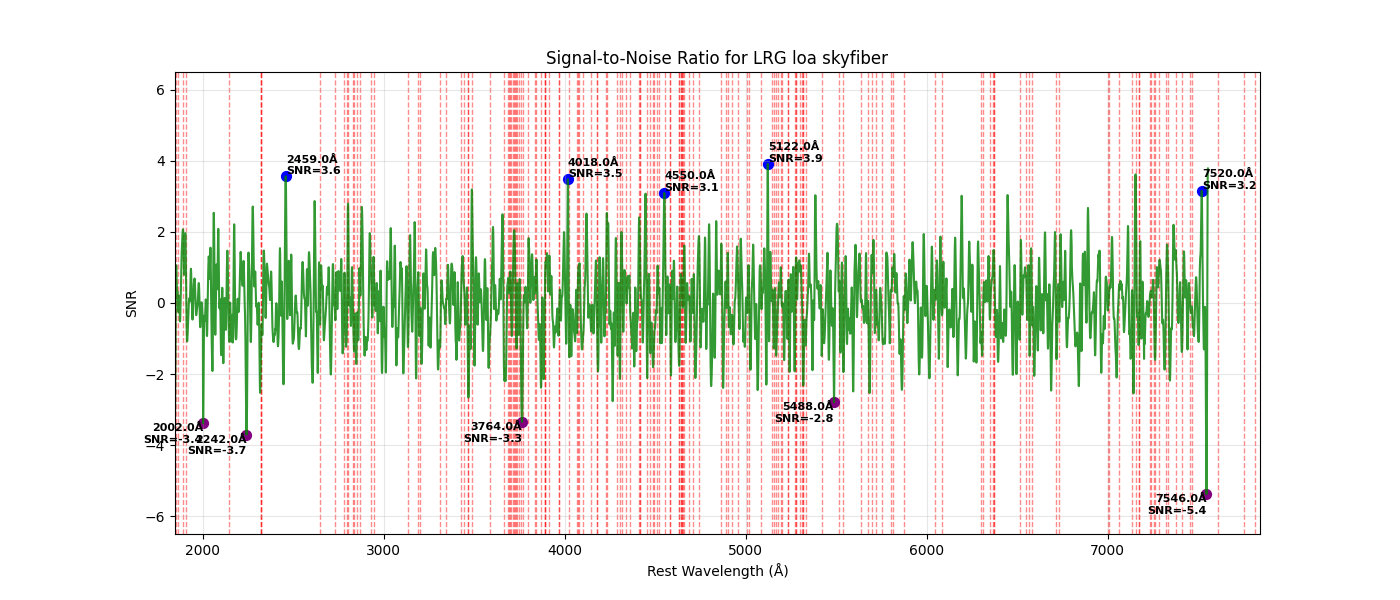

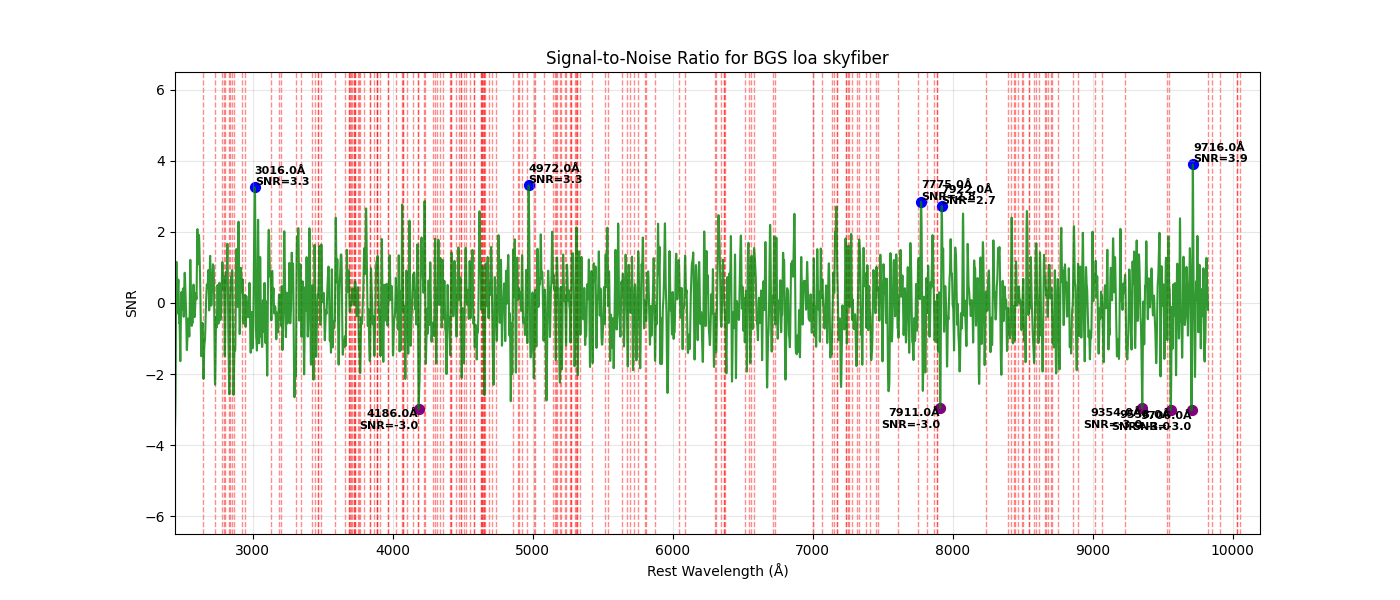

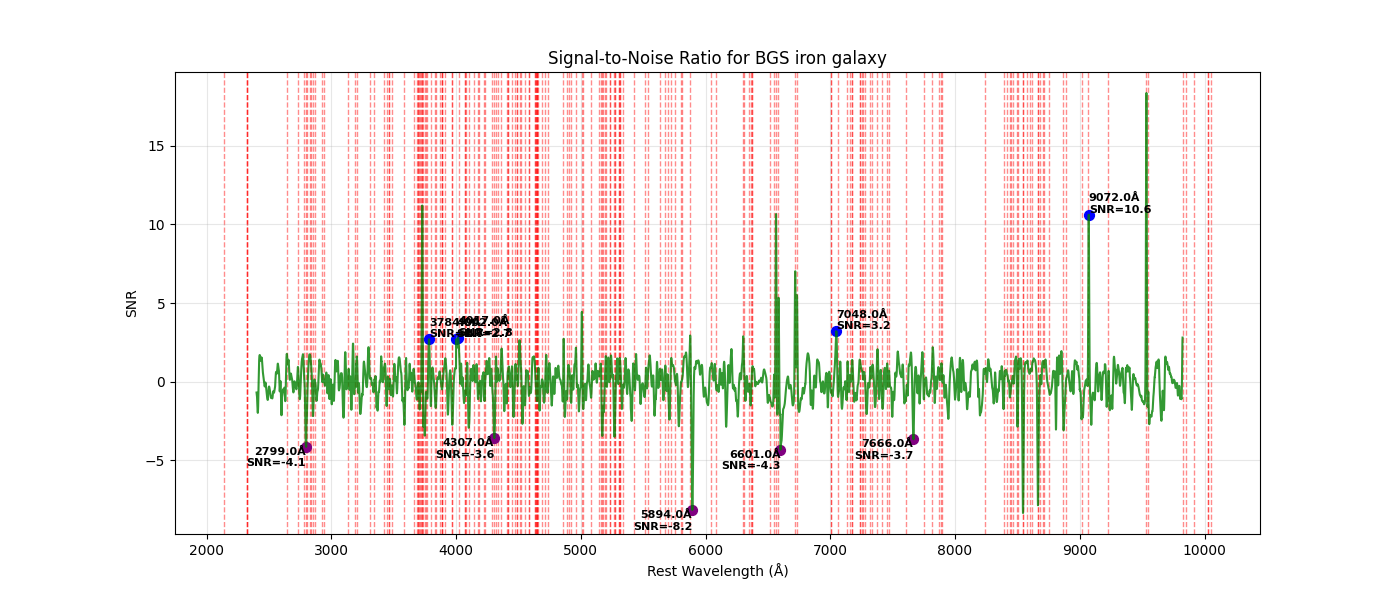

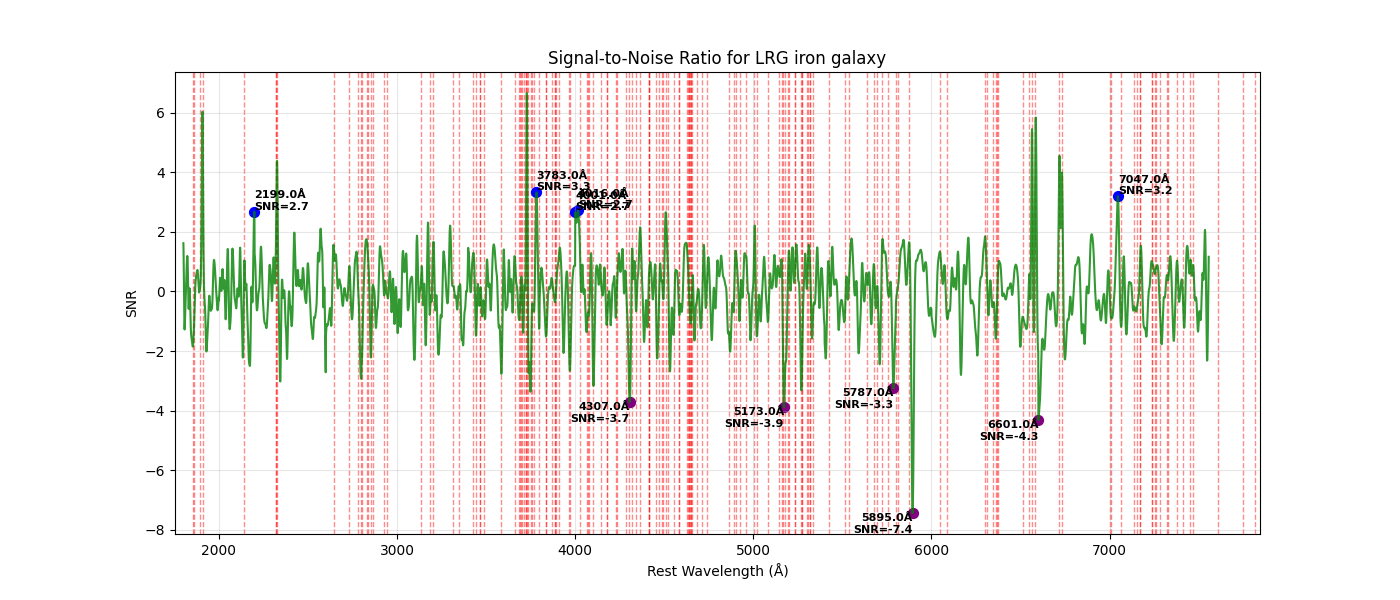

In [ ]:
def create_graph(gal_type,dataset,runtype):
    valid_snr_narrow,noise,valid_wave = load_results(gal_type,dataset,runtype)
    plot_SNR(valid_snr_narrow,valid_wave,gal_type,dataset,runtype)

create_graph('LRG','loa','skyfiber')
create_graph('BGS','loa','skyfiber')
create_graph('LRG','iron','skyfiber')
create_graph('BGS','iron','skyfiber')

create_graph('BGS','loa','galaxy')
create_graph('LRG','loa','galaxy')
create_graph('BGS','iron','galaxy')
create_graph('LRG','iron','galaxy')